# POBRANIE DATASETU

In [1]:
import numpy as np
import pandas as pd

In [ ]:
import gdown
import zipfile
import os
""" 
DATASET TAKEN FROM KAGGLE:
    https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification/data
"""

file_id = "1i4VQ53DZ9ntbzVTGPdyG5IeZ_UyIEAJw"
output = "butterflies_zip.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

# unziiping
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("butterflies")

os.listdir("butterflies")


Downloading...
From (original): https://drive.google.com/uc?id=1i4VQ53DZ9ntbzVTGPdyG5IeZ_UyIEAJw
From (redirected): https://drive.google.com/uc?id=1i4VQ53DZ9ntbzVTGPdyG5IeZ_UyIEAJw&confirm=t&uuid=3305ec84-9006-42ae-b03d-895009dec623
To: /content/butterflies_zip.zip
100%|██████████| 237M/237M [00:02<00:00, 94.8MB/s]


['Testing_set.csv', 'Training_set.csv', 'test', 'train']

# EKSPLORACJA DATASETU

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3


In [4]:
df = pd.read_csv("butterflies/Training_set.csv")
df.head(5)

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [5]:
df.shape

(6499, 2)

In [6]:
len(df.label.unique()) #klasy

75

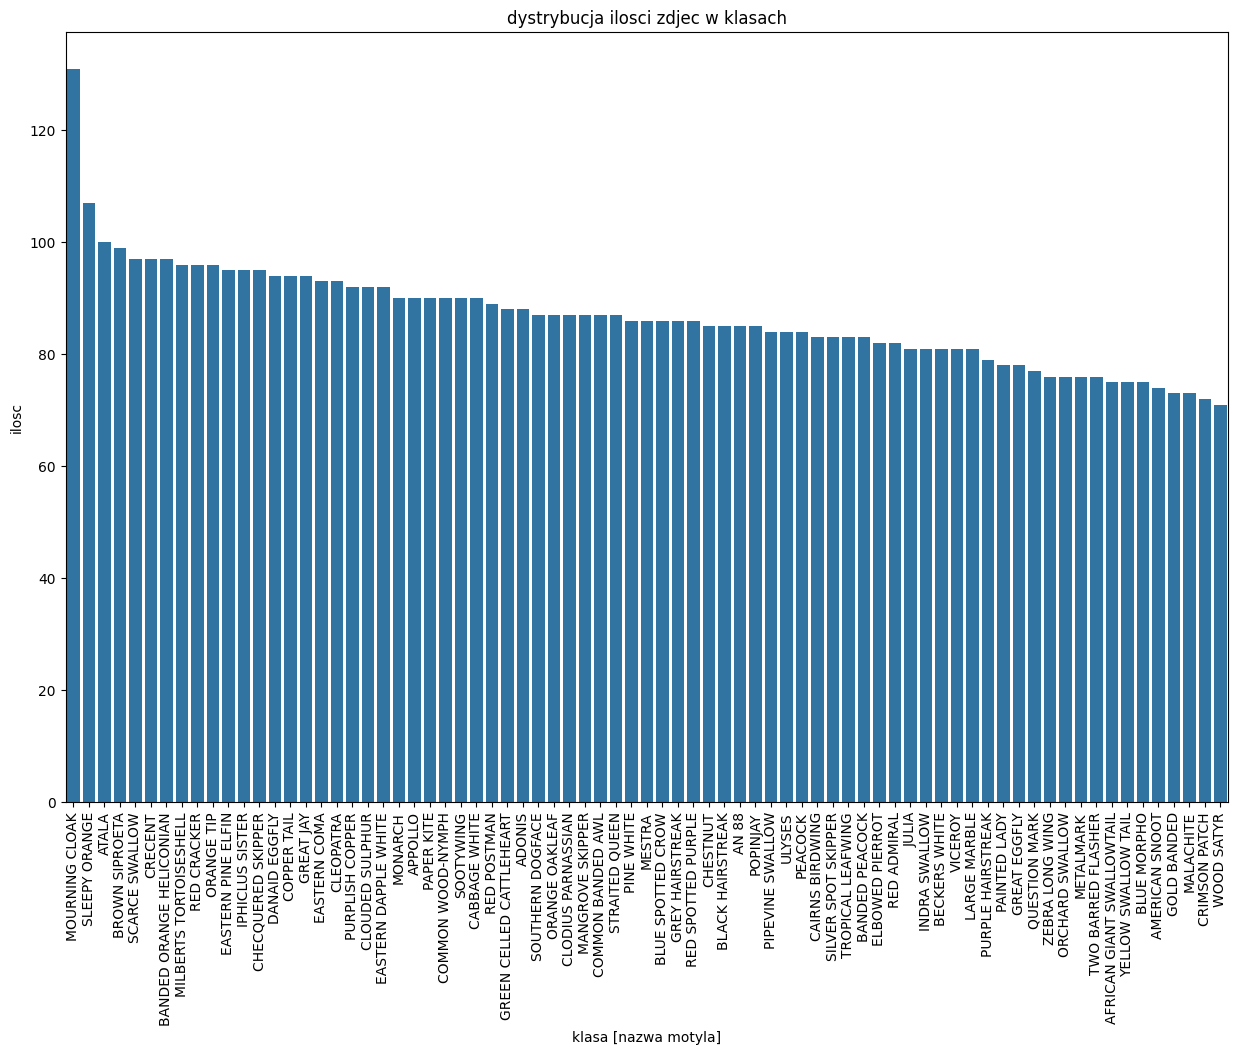

In [7]:
label_distribution = df['label'].value_counts()
plt.figure(figsize=(15, 10))
sns.barplot(x=label_distribution.index, y=label_distribution.values)
plt.title('dystrybucja ilosci zdjec w klasach')
plt.xlabel('klasa [nazwa motyla]')
plt.ylabel('ilosc')
plt.xticks(rotation=90)
plt.show()

# Trenowanie modelu na sieci ResNet50 od zera (bez transfer learningu) na CPU

In [8]:
train_dir = r'butterflies/train'
test_dir = r'butterflies/test'

In [10]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

image_dir = "butterflies/train"

img_gen = ImageDataGenerator()

train = img_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    class_mode='categorical'
)

validation = img_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    class_mode='categorical'
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


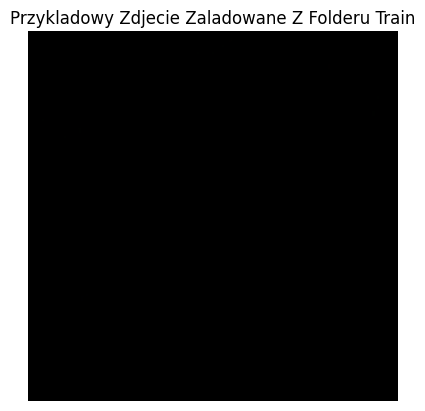

In [ ]:
def sample_image():
  images, labels = next(train)

  plt.imshow(images[2].astype(np.uint8))
  plt.title(f"Przykladowy Zdjecie Zaladowane Z Folderu Train")
  plt.axis('off')
  plt.show()

sample_image()
# accidentaly clicked it after normalizing it below; will fix it

In [ ]:
train[0] #rgb wartosci zdjec;; przed normalizacją

(array([[[[100., 111.,  17.],
          [100., 111.,  19.],
          [101., 112.,  20.],
          ...,
          [ 88.,  58.,  20.],
          [ 91.,  61.,  23.],
          [ 87.,  57.,  19.]],
 
         [[110., 121.,  19.],
          [107., 117.,  18.],
          [107., 117.,  20.],
          ...,
          [ 86.,  58.,  19.],
          [ 85.,  57.,  18.],
          [ 89.,  61.,  22.]],
 
         [[122., 131.,  26.],
          [120., 128.,  27.],
          [121., 129.,  30.],
          ...,
          [ 89.,  61.,  22.],
          [ 87.,  59.,  20.],
          [ 88.,  60.,  21.]],
 
         ...,
 
         [[142., 148.,  26.],
          [141., 146.,  26.],
          [138., 143.,  25.],
          ...,
          [154., 128.,  33.],
          [167., 136.,  45.],
          [197., 158.,  79.]],
 
         [[143., 149.,  25.],
          [141., 147.,  25.],
          [138., 143.,  23.],
          ...,
          [163., 139.,  43.],
          [181., 154.,  63.],
          [190., 158.,  75.

In [31]:
def plot_training_history(history):

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [33]:
class_count = len(train.class_indices)
class_count

75

In [35]:
img_height = 150
img_width = 150

In [36]:
base_model = ResNet50(include_top=False,
                      weights=None,
                      classes=class_count)

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(75, activation='sigmoid')(x) #zmienić na softmax
model = tf.keras.Model(inputs=base_model.input, outputs=x)

In [37]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,741,387 (90.57 MB)

 Trainable params: 23,688,267 (90.36 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [38]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
history = model.fit(train, validation_data=validation, epochs=10)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 346ms/step - accuracy: 0.0508 - loss: 5.0859 - val_accuracy: 0.0500 - val_loss: 5.8205
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 177ms/step - accuracy: 0.2018 - loss: 3.0856 - val_accuracy: 0.1938 - val_loss: 3.0282
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 181ms/step - accuracy: 0.3393 - loss: 2.4077 - val_accuracy: 0.1338 - val_loss: 5.2361
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 180ms/step - accuracy: 0.4453 - loss: 1.9586 - val_accuracy: 0.1969 - val_loss: 4.6290
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 181ms/step - accuracy: 0.5242 - loss: 1.6643 - val_accuracy: 0.3131 - val_loss: 3.4833
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 180ms/step - accuracy: 0.6262 - loss: 1.2949 - val_accuracy: 0.4969 - val_loss: 1.8347
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 180ms/step - accuracy: 0.6960 - loss: 1.0418 - val_accuracy: 0.2238 - val_loss: 16.2908
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 180ms/step - accuracy: 0.7070 - loss: 0.9671 - v

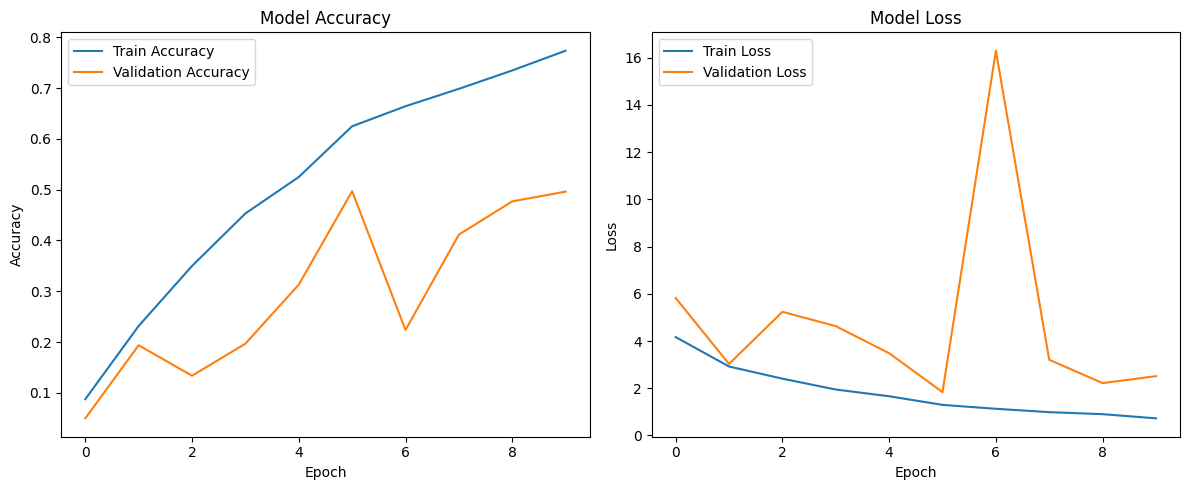

In [40]:
plot_training_history(history)

## CPU
CZAS: 1 EPOKA PONAD GODZINĘ; ŁĄCZNIE OKOŁO 10 H.

WYNIK: ...

## T4
CZAS: 7 MINUT

WYNIK [ACCURACY]: 0.78; 78%

Z tak dużym dataset'em nie da się fizycznie odpalić tego modelu na CPU, zajęło by to możliwie z ponad 10 godzin.


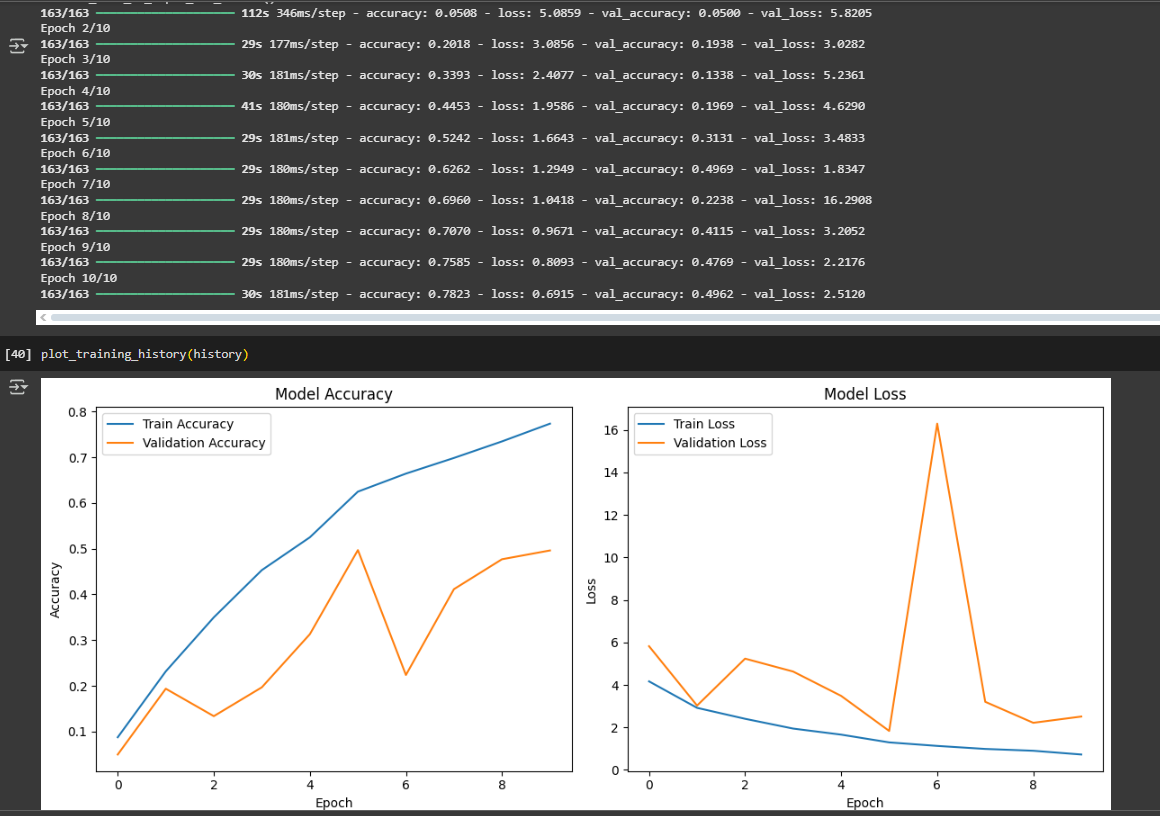

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


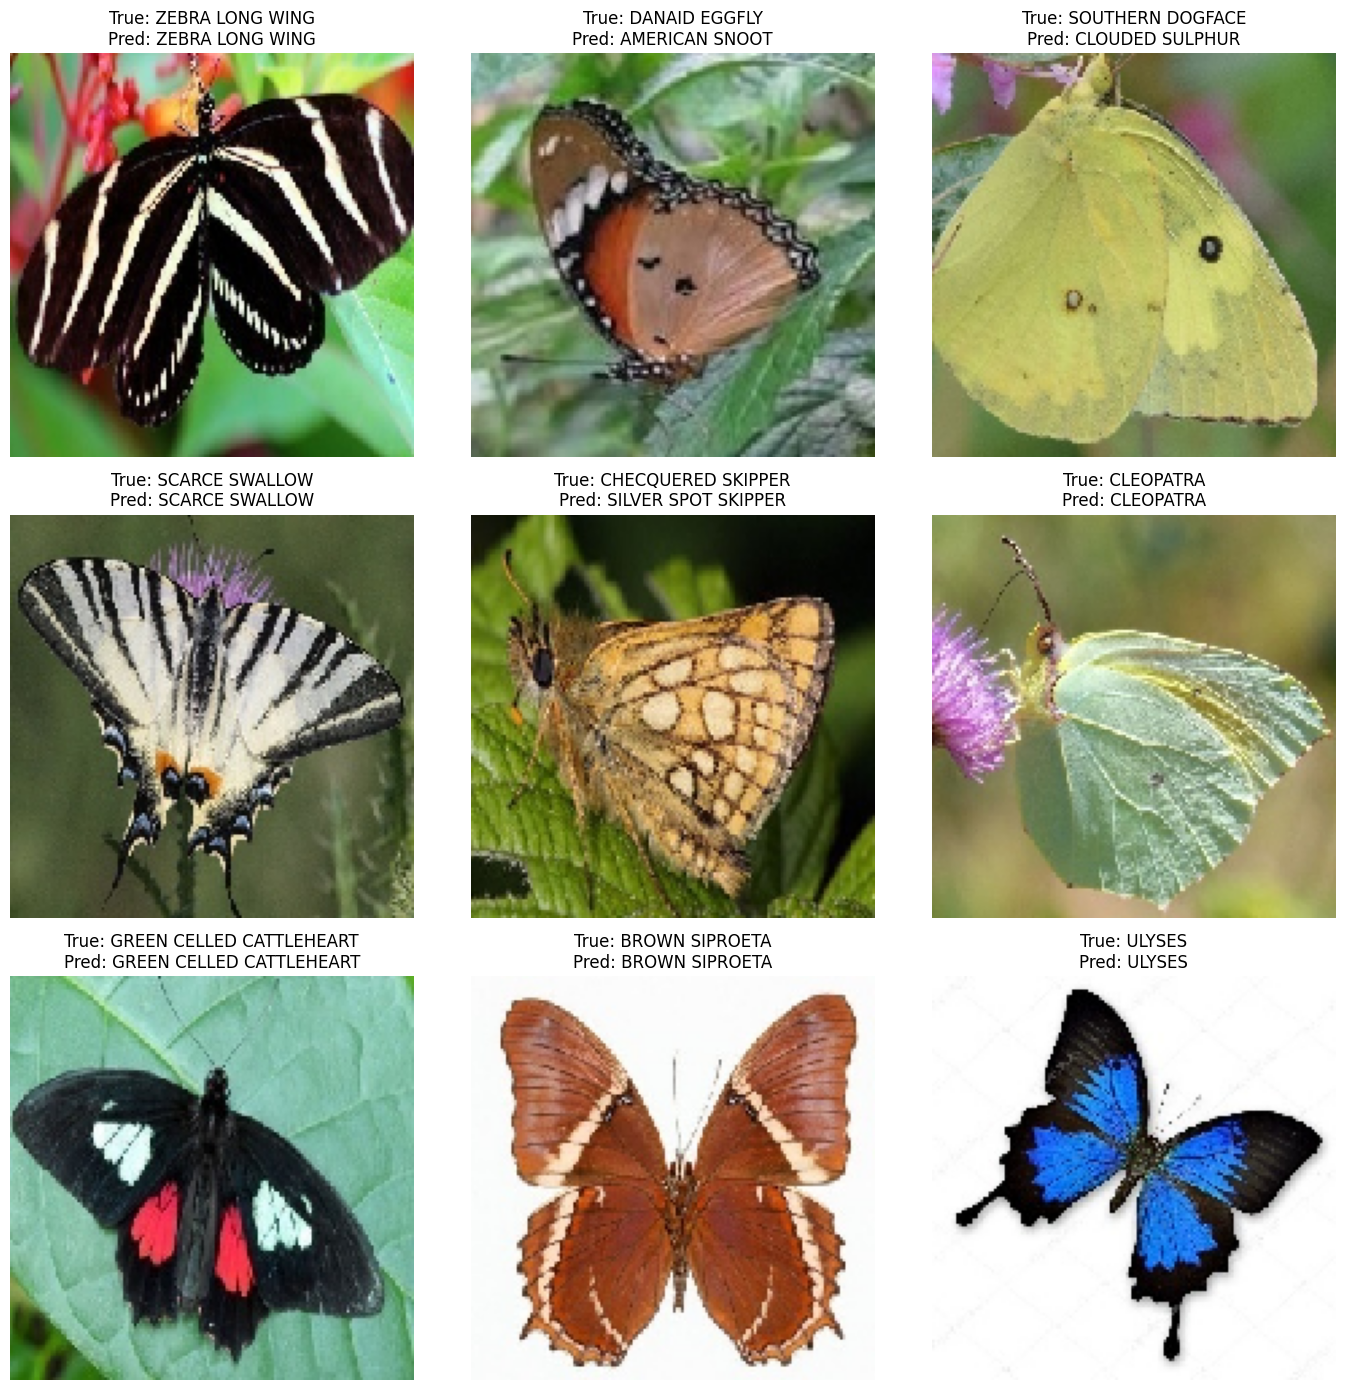

In [ ]:
def predict_butterflies():
    val_images, val_labels = next(validation)

    pred_labels = model.predict(val_images)
    pred_labels = np.argmax(pred_labels, axis=1)
    true_labels = np.argmax(val_labels, axis=1)

    class_indices = validation.class_indices
    class_names = {v: k for k, v in class_indices.items()}

    def display_images(images, true_labels, pred_labels, class_names, num_images=9):
        plt.figure(figsize=(14, 14))
        for i in range(num_images):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].astype(np.uint8))
            true_label = class_names[int(true_labels[i])]
            pred_label = class_names[int(pred_labels[i])]
            plt.title(f"True: {true_label}\nPred: {pred_label}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    display_images(val_images, true_labels, pred_labels, class_names, num_images=9)

predict_butterflies();

## TRANSFER LEARNING

In [63]:
base_model = ResNet50(
    weights='imagenet', #transfer learning
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False #zamrozenie wag

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(75, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=x)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy']) #model za szybko się uczył i dochodził do sufitu przy 5 epoce więc zmniejszam learning rate

In [65]:
history_tl = model.fit(train, validation_data=validation, epochs=10)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - accuracy: 0.0183 - loss: 5.1327 - val_accuracy: 0.0669 - val_loss: 4.0543
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.1267 - loss: 3.6950 - val_accuracy: 0.2269 - val_loss: 3.1463
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.3274 - loss: 2.8204 - val_accuracy: 0.3792 - val_loss: 2.5318
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.4848 - loss: 2.2180 - val_accuracy: 0.4915 - val_loss: 2.1103
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.5885 - loss: 1.8019 - val_accuracy: 0.5615 - val_loss: 1.8112
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.6611 - loss: 1.5032 - val_accuracy: 0.6046 - val_loss: 1.6038
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.7187 - loss: 1.3045 - val_accuracy: 0.6531 - val_loss: 1.4483
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.7606 - loss: 1.1313 - 

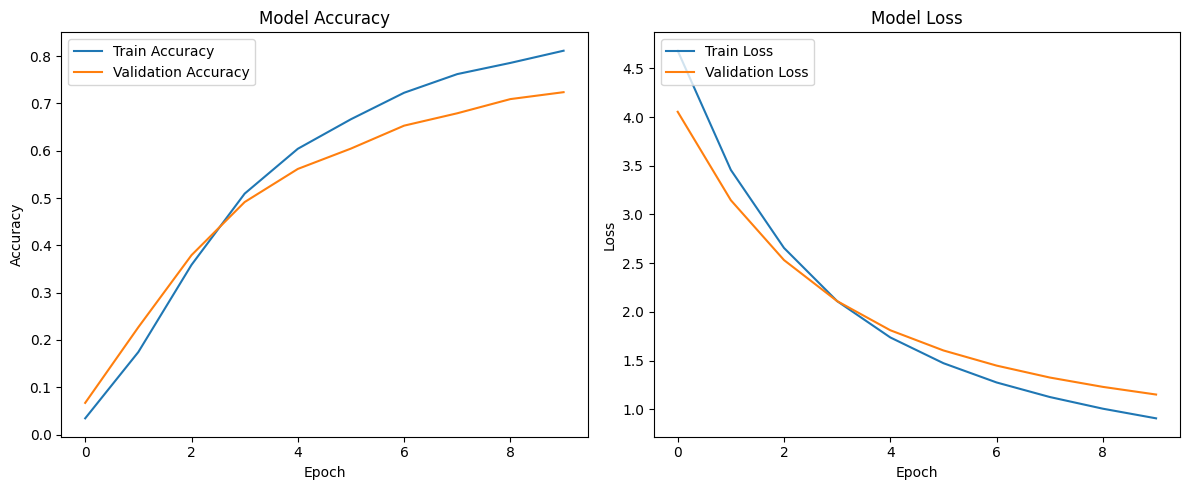

In [66]:
plot_training_history(history_tl)

### TRANSFER LEARNING REPORT:

#### CZAS:
Jeden step zajmuje między 50-100ms gdy poprzednio zajmował 180-300ms

Samo trenowanie na T4 zajęło minutę; bez transfer learningu na T4 około 7 minut.

#### WYNIKI:
80% dokładności; bez transfer learningu wynosiło 78%.

Jednak różnią się diametralnie wykresami;

Dokładność walidacyjna jest dużo wyższa niż poprzednio i jest ona stabilna.

Straty tak samo dużo stabilniej wyglądają oraz nie skaczą; stopniowo się zmniejszają.


# OPTYMALIZACJA


## a. normalizację - przygotować raport porównawczy z normalizacją danych i bez.


In [89]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [101]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

image_dir = "butterflies/train"

img_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input # normalizacja!
        )

train = img_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    class_mode='categorical'
)

validation = img_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    class_mode='categorical'
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


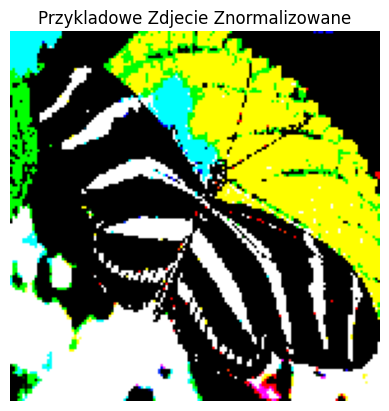

In [102]:
def sample_image():
    images, labels = next(train)
    plt.imshow(images[2])
    plt.title("Przykladowe Zdjecie Znormalizowane")
    plt.axis('off')
    plt.show()

sample_image()

In [103]:
base_model = ResNet50(
    weights='imagenet', #transfer learning
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False #zamrozenie wag

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(75, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=x)

In [104]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

In [105]:
history_tl_nor = model.fit(train, validation_data=validation, epochs=10)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 118ms/step - accuracy: 0.0271 - loss: 5.0012 - val_accuracy: 0.0985 - val_loss: 3.8531
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.1823 - loss: 3.4304 - val_accuracy: 0.3262 - val_loss: 2.8761
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.4207 - loss: 2.5311 - val_accuracy: 0.4854 - val_loss: 2.2358
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.5790 - loss: 1.9303 - val_accuracy: 0.5808 - val_loss: 1.8160
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.6877 - loss: 1.5255 - val_accuracy: 0.6431 - val_loss: 1.5310
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.7441 - loss: 1.2555 - val_accuracy: 0.6854 - val_loss: 1.3378
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.8029 - loss: 1.0472 - val_accuracy: 0.7246 - val_loss: 1.1917
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.8344 - loss: 0.9064 - val_accura

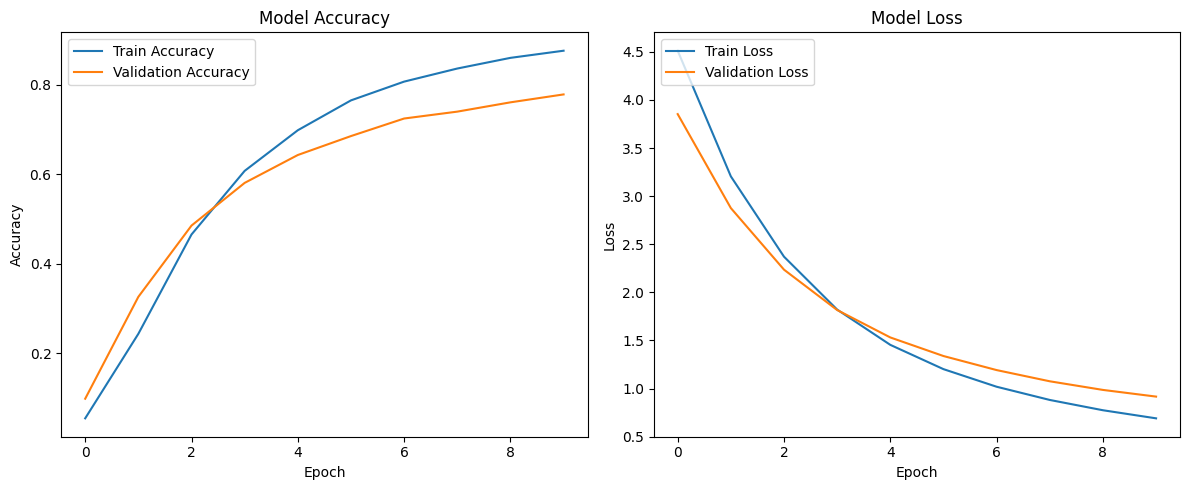

In [108]:
plot_training_history(history_tl_nor)

### PO NORMALIZACJI REPORT:

#### CZAS:

bez: MINUTA

z: 2 MINUTY

#### WYNIK:
bez: około 80%, val_accuracy: 0.7238

z: 86% dokładności, val_accuracy: 0.7785

Jak widać, wyniki się znacznie polepszyły a jest to do czego dążymy :]

## b. augumentację danych - przygotować raport porównawczy z augumentacją i bez + informacją jakie przekształcenia zostały przeprowadzone.

In [109]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

image_dir = "butterflies/train"

In [112]:
# augumentacja danych: polega na wprowadzeniu do materiału treningowego nieco zmodyfikowanych kopii istniejących danych:)

img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # normalizacja!
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [111]:
train = img_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    class_mode='categorical'
)

validation = img_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    class_mode='categorical'
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


In [ ]:
base_model = ResNet50(
    weights='imagenet', #transfer learning
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False #zamrozenie wag

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(75, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=x)

In [ ]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_tl_au = model.fit(train, validation_data=validation, epochs=10)

In [ ]:
plot_training_history(history_tl_au)

## c. dropout - przygotować raport porównawczy z zastosowaniem dropoutu i bez.


## d. dokładanie danych - przygotować raport porównawczy z dołożeniem nowej partii danych i bez.


## e. różne rozmiary wejściowe (np. 96x96, 160x160, 224x224) - przygotować raport porównawczy dla każdego rozmiaru.


## f. różny rozmiar Batch size (np. 32, 64, 128) - przygotować raport porównawczy dla każdego rozmiaru.


## g. różne struktury sieci (np. VGG16, ResNet101, InceptionV3, MobileNet) - przygotować raport porównawczy dla każdej sieci (min. 4).